In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import math
import random
import pandas as pd
import seaborn as sns
from __future__ import division
import time
from distutils.log import error
import errno
from datetime import date
import pyomo.environ as pyo
import parameters
from pyomo.environ import *
%matplotlib inline

<font size="5"> COLLECTING SOLAR PANEL DATA

In [3]:
# Import the particular module of the pvlib library
import pvlib
from pvlib import pvsystem

# CEC PV Module Database
cec_mod_db = pvsystem.retrieve_sam('CECmod')

#inverter Database
invdb = pvsystem.retrieve_sam('CECInverter')
# Accessing the characteristics of one of the Inverters randomly
inverter_data = invdb.iloc[:, np.random.randint(0, high=len(invdb))]

In [4]:
#weather data from closest NREL Weather station https://midcdmz.nrel.gov/apps/data_api_doc.pl?_idtextlist
!pip install --default-timeout=100 NREL-PySAM

df_weather = pvlib.iotools.read_midc_raw_data_from_nrel('UOSMRL',               # Station id(cal poly) 
                                                    pd.Timestamp('20210101'),   # Start date YYYYMMDD
                                                    pd.Timestamp('20210131'))   # End date  YYYYMMDD

# Let's see the head, shape and columns of the data
df_weather.head(3)

,Unnamed: 0,Year,DOY,PST,Unnamed: 4,Direct NIP [W/m^2],Diffuse Schenk [W/m^2],Global LI-200 [W/m^2],Relative Humidity [%],Air Temperature [deg C],...,CHP1 Temp [deg K],CMP22 Temp [deg K],Avg Wind Direction @ 10m [deg from N],Zenith Angle [degrees],Azimuth Angle [degrees],Airmass,Solar Eclipse Shading,Direct SAMPA/Bird (calc) [W/m^2],Global SAMPA/Bird (calc) [W/m^2],Diffuse SAMPA/Bird (calc) [W/m^2]
2021-01-01 00:00:00-08:00,0,2021,1,0,-0.002,0.000,-1.057,0.017,80.8,9.05,...,282.0,283.2,131.4,158.67385,349.90342,-1.0,0,0.0,0.0,0.0
2021-01-01 00:01:00-08:00,0,2021,1,1,0.002,0.123,-1.039,0.030,80.6,9.09,...,281.9,283.2,149.0,158.70431,350.53096,-1.0,0,0.0,0.0,0.0
2021-01-01 00:02:00-08:00,0,2021,1,2,0.005,0.181,-1.041,0.028,80.3,9.10,...,281.9,283.2,150.8,158.73283,351.16003,-1.0,0,0.0,0.0,0.0


In [5]:
df_weather = df_weather[['Global CMP22 [W/m^2]', 'Diffuse Schenk [W/m^2]', 
                         'Direct CHP1 [W/m^2]','Air Temperature [deg C]', 'Avg Wind Speed @ 10m [m/s]']]
# Rename the columns
df_weather.columns = ['ghi', 'dhi', 'dni', 'temp_air', 'wind_speed']
# See the first columns of our weather dataset

df_weather.head(3)

,ghi,dhi,dni,temp_air,wind_speed
2021-01-01 00:00:00-08:00,-0.236,-1.057,0.071,9.05,1.450
2021-01-01 00:01:00-08:00,-0.217,-1.039,0.170,9.09,1.675
2021-01-01 00:02:00-08:00,-0.183,-1.041,0.114,9.10,2.000


In [7]:
#DEFINING CHARACTERISTICS OF PV SYSTEM

# Coordinates 
latitude = 44.0467
longitude = -123.0743
altitude = 133.8

# Define the location object
location = pvlib.location.Location(latitude, longitude, altitude=altitude)

# Define Temperature Paremeters 
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# Define the PV Module and the Inverter from the CEC databases (random)
module_data = cec_mod_db.iloc[:,0]
inverter_data = invdb.iloc[:, np.random.randint(0, high=len(invdb))]

# Define the basics of the class PVSystem
system = pvlib.pvsystem.PVSystem(surface_tilt=30, surface_azimuth=180,
                                 module_parameters=module_data,
                                 inverter_parameters=inverter_data,
                                 temperature_model_parameters=temperature_model_parameters)

# Creation of the ModelChain object
""" The example does not consider AOI losses nor irradiance spectral losses"""
mc = pvlib.modelchain.ModelChain(system, location, 
                                 aoi_model='no_loss', 
                                 spectral_model='no_loss',
                                 name='AssessingSolar_PV')

# Pass the weather data to the model
""" 
The weather DataFrame must include the irradiance components with the names 'dni', 'ghi', and 'dhi'. 
The air temperature named 'temp_air' in degree Celsius and wind speed 'wind_speed' in m/s are optional.
"""
mc.run_model(df_weather) 

C:\Users\baron\anaconda3\envs\microgrid\lib\site-packages\pvlib\tools.py:340: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))


ModelChain: 
  name: AssessingSolar_PV
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: sandia_inverter
  aoi_model: no_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

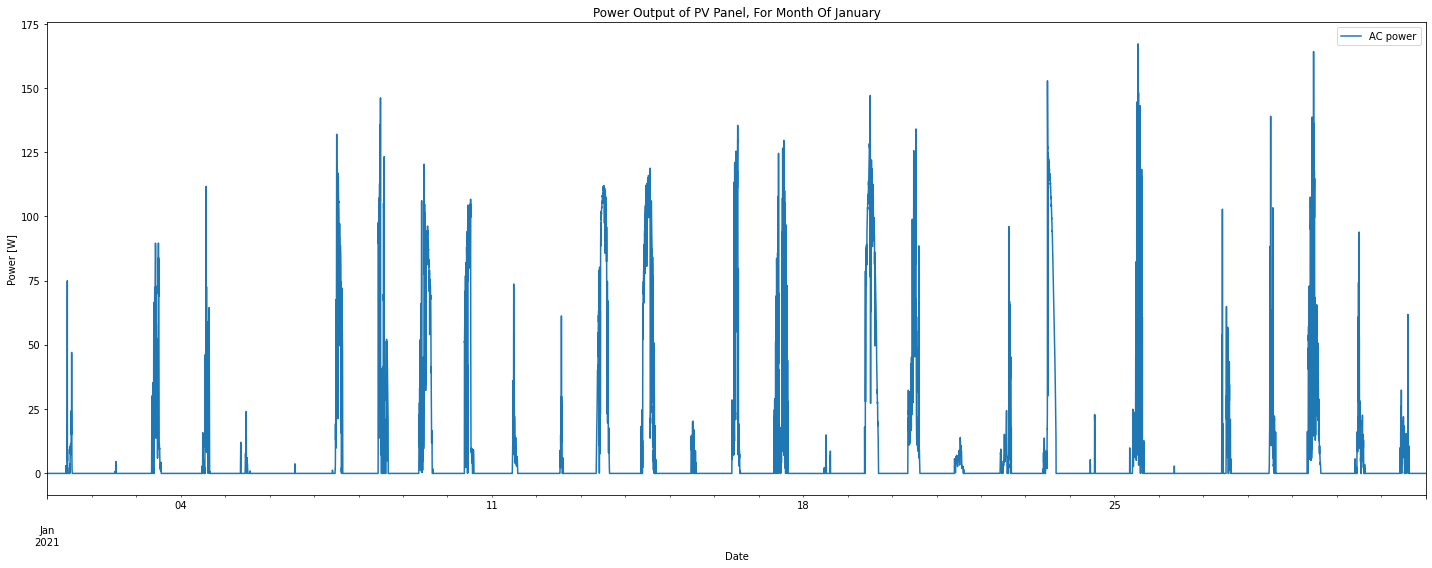

In [8]:
# Plot of Power Output 
fig, ax = plt.subplots(figsize=(20, 8))

#x=1.576*0.825*mc.results.weather['dhi']

#x.plot()
#mc.results.weather['dhi'].plot(label='irrad')
ax = mc.results.ac.plot(label='AC power')
#mc.results.dc['p_mp'].plot(label='DC power')
#ax.xaxis.set_major_formatter(DateFormatter("%m-%d"))
ax.set_ylabel('Power [W]')
ax.set_xlabel('Date')
ax.set_title('Power Output of PV Panel, For Month Of January')
plt.legend()
plt.tight_layout()
plt.show() 

In [9]:
#collecting panel output (over 15 min intervals) to a df
ac_array = mc.results.ac.values

ac_array= [sum(ac_array[i:i+15]) for i in range(0, len(ac_array), 15)]

for i in range(len(ac_array)):
    if ac_array[i] < 0:
        ac_array[i] = 0
        
PV_Data = pd.DataFrame(ac_array, columns = ['Solar_output'])
print(PV_Data)

      Solar_output
0              0.0
1              0.0
2              0.0
3              0.0
4              0.0
...            ...
2971           0.0
2972           0.0
2973           0.0
2974           0.0
2975           0.0

[2976 rows x 1 columns]


<font size="5"> HOUSEHOLD DATA

In [10]:
User_Data = pd.read_csv('./15minute_data_austin.csv')

# get_all_values gives a list of rows.
print(User_Data)


       dataid       local_15min Unnamed: 2   grid  solar  solar2  \
0       661.0          1/1/2018       0:00    NaN    NaN     NaN   
1       661.0          1/1/2018       0:15    NaN    NaN     NaN   
2       661.0          1/1/2018       0:30    NaN    NaN     NaN   
3       661.0          1/1/2018       0:45    NaN    NaN     NaN   
4       661.0          1/1/2018       1:00  1.447 -0.002     NaN   
...       ...               ...        ...    ...    ...     ...   
65537  1642.0  11/18/2018 17:15        NaN  1.743 -0.026     NaN   
65538  1642.0  11/18/2018 17:30        NaN  3.941 -0.020     NaN   
65539  1642.0  11/18/2018 17:45        NaN  4.326 -0.021     NaN   
65540  1642.0  11/18/2018 18:00        NaN  4.806 -0.016     NaN   
65541  1642.0  11/18/2018 18:15        NaN  3.944 -0.008     NaN   

       Whole Home Use  
0               0.000  
1               0.000  
2               0.000  
3               0.000  
4               1.445  
...               ...  
65537          

<font size="5"> STORE DATA IN A SERIES

In [11]:
prof=pd.Series(dtype='object')

#prof.loc['Date']=User_Data.iloc[:,1]
# prof.loc['Time']=User_Data.iloc[:96,1]
# prof.loc['Solar']=PV_Data.iloc[:,0]*0.00025 #convert to kWh
# prof.loc['Load']=User_Data.iloc[:96, 6]*.25   #convert to kWh 

prof.loc['Time']=User_Data.iloc[:2976 ,1]
prof.loc['Solar']=PV_Data.iloc[:,0]*0.00025 #convert to kWh
prof.loc['Load']=User_Data.iloc[:2976, 6]*.25   #convert to kWh 

print(prof.Solar)
print(prof.Load)
print(prof.Time)


0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2971    0.0
2972    0.0
2973    0.0
2974    0.0
2975    0.0
Name: Solar_output, Length: 2976, dtype: float64
0       0.00000
1       0.00000
2       0.00000
3       0.00000
4       0.36125
         ...   
2971    1.01725
2972    0.97050
2973    0.15700
2974    0.13500
2975    0.15675
Name: Whole Home Use, Length: 2976, dtype: float64
0        1/1/2018
1        1/1/2018
2        1/1/2018
3        1/1/2018
4        1/1/2018
          ...    
2971    1/31/2018
2972    1/31/2018
2973    1/31/2018
2974    1/31/2018
2975    1/31/2018
Name: local_15min, Length: 2976, dtype: object


<font size="5"> PYOMO OPTIMIZATION FUNCTION

In [21]:
def microgrid(Nbmax,Npmax,LoadFactor=1):
    
    m = ConcreteModel()
    
    # Time
    T = np.shape(prof.Time)[0]
    m.k = RangeSet(0,T-1)
    
    # Scalar Parameters
    m.Cgi = Param(initialize=0.1990) #average cost of electricity in California ($/kWh)
    m.Cs = Param(initialize=0.08) #average cost of solar in US ($/kWh)
    m.Cb = Param(initialize=.75) #predicted cost of battery in 2022 ($/kWh)
    m.Cge = Param(initialize=0.03) #PGE average sell to grid rate ($/kWh)
    m.eta_b = Param(initialize=0.85) #discharging efficiency
    m.r = Param(initialize=0.004) # Real interest rate
    m.MaxPanels = Param(initialize=Npmax//1.6) #Max Allowed Solar Panels (m2/m2)
    m.SolarEng = Param(initialize=1.5)
    
    
    # Indexed Parameters
    m.Solar = Param(m.k,initialize=dict(enumerate(prof.Solar,0)))
    m.Load = Param(m.k,initialize=dict(enumerate(prof.Load*LoadFactor,0)))
   
    # Variables
    m.Np = Var(within=PositiveReals,bounds = (0,m.MaxPanels),initialize=m.MaxPanels) #Number of Panels
    m.Nb = Var(within=PositiveReals,bounds=(0,Nbmax),initialize=Nbmax) #Battery Capacity (kWh)
    m.SOC = Var(m.k, within=NonNegativeReals, bounds=(0,Nbmax),initialize=Nbmax) #Battery SOC (kWh)
    m.Bc = Var(m.k, within=NonNegativeReals, initialize=0) #Battery Charge (kWh)
    m.Bd = Var(m.k, within=NonNegativeReals,initialize=0) #Batttery Discharge (kWh)
    m.Ge = Var(m.k, within=NonNegativeReals, initialize=0) #Give to grid (kWh)
    m.Gi = Var(m.k, within=NonNegativeReals,initialize = 0)  #Take from grid (kWh)
    m.C = Var(m.k, within=NonNegativeReals,initialize=m.Load[0]) #Supplied to Demand (kWh)
    m.S = Var(m.k,within=NonNegativeReals, initialize=0) #Actual Supplied to System (kWh)
    
    #Objective
    def ObjF(m):
        return m.Cs*m.Np*m.SolarEng + m.Cb*m.Nb + sum(m.Cgi*m.Gi[k] - m.Cge*m.Ge[k] for k in m.k)
    m.Cost = Objective(rule=ObjF)

    #Constraints
    def TotalBalance(m,k):
        return (m.S[k] + m.Gi[k] + m.Bd[k] == m.Ge[k] + m.Bc[k] + m.C[k])
    m.TotalBalance = Constraint(m.k,rule=TotalBalance)
    
    def SolarBalance(m,k):
        return (m.Solar[k]*m.Np == m.S[k])
    m.SolarBalance = Constraint(m.k,rule=SolarBalance)
    
    def SOClower(m,k):
        m.SOC[0] == m.Nb
        return (0,m.SOC[k],None)
    m.SOClower = Constraint(m.k,rule=SOClower)
    
    def SOCupper(m,k):
        m.SOC[0] == m.Nb
        return (None, m.SOC[k]-m.Nb,0)
    m.SOCupper = Constraint(m.k,rule=SOCupper)
    
    def SOCBalance(m,k):
        m.SOC[0] == m.Nb
        if k<=T-2:
            return (m.SOC[k+1] == m.SOC[k] + m.eta_b*m.Bc[k] - m.Bd[k]/m.eta_b)
        else:
            return (m.SOC[k]== m.SOC[k] + m.eta_b*m.Bc[k] - m.Bd[k]/m.eta_b)
    m.SOCBalance = Constraint(m.k,rule=SOCBalance)

    def DeltaB(m,k):
        if k<T-2:
            return (None,m.SOC[k+1]-m.SOC[k]-(m.Nb/4),0)
        else:
            return (None,m.SOC[k]-(m.Nb/4),0)
    m.DeltaB = Constraint(m.k,rule=DeltaB)
    
    def Discharge(m,k):
        return (None,m.eta_b*m.Bd[k]-m.SOC[k],0)
    m.Discharge = Constraint(m.k,rule=Discharge)
    
    def Charge(m,k):
        return (None,m.Bc[k]+m.SOC[k]-m.Nb,0)
    m.Charge = Constraint(m.k,rule=Charge)

    def TakeGridBalance(m,k):
        return (0,m.Gi[k],m.Load[k])
    m.TakeGridBalance = Constraint(m.k,rule=TakeGridBalance)
    
    def GiveGridBalanceLower(m,k):
        return (0,m.Ge[k],None)
    m.GiveGridBalanceLower = Constraint(m.k,rule=GiveGridBalanceLower)
    
    def GiveGridBalanceUpper(m,k):
        return (None,m.Ge[k]-m.Load[k]-m.Bc[k],0)
    m.GiveGridBalanceUpper = Constraint(m.k,rule=GiveGridBalanceUpper)
    
    def LoadBalance(m,k):
    #         return (m.Load[k], m.C[k], None) # Can be changed to adapt
        return m.Load[k] == m.C[k]
    
    m.LoadBalance = Constraint(m.k,rule=LoadBalance)
    
    
    #Solve
    solver = SolverFactory('glpk')
    solver.options['tmlim'] = 300
    results = solver.solve(m)
    
    
    # Final Values
    Time = np.zeros((T,1))
    Time = np.arange(0,T,1)
    Load = np.zeros((T,1))
    Price = np.zeros((T,1))
    Solar_Obtained = np.zeros((T,1))
    SOC = np.zeros((T,1))
    Bc = np.zeros((T,1))
    Bd = np.zeros((T,1))
    Gi = np.zeros((T,1))
    Ge = np.zeros((T,1))
    C = np.zeros((T,1))
    
    for k in range(len(m.k)):
        Load[k] = value(m.Load[k])
        Price[k] = value(m.Cgi)*value(m.Gi[k])+value(m.Cs)*value(m.Np)+value(m.Cb)*value(m.Np)-value(m.Cge)*value(m.Ge[k])
        Solar_Obtained[k] = value(m.S[k])
        SOC[k] = value(m.SOC[k])
        Bc[k] = value(m.Bc[k])
        Bd[k] = value(m.Bd[k])
        Gi[k] = value(m.Gi[k])
        Ge[k] = value(m.Ge[k])
        C[k] = value(m.C[k])
    
    # Plot 
    plt.figure(figsize = (15,10))
    plt.plot(Time[:960],Load[:960])
    
    #     plt.plot(Time,C)
    plt.plot(Time[:960],Solar_Obtained[:960])
    plt.plot(Time[:960],SOC[:960])
    plt.plot(Time[:960],Gi[:960])
    plt.plot(Time[:960],Ge[:960])
    plt.legend(['Load','Solar','SOC','Grid import','Grid export'])
    plt.ylabel('Power [kWh]')
    plt.xlabel('Time Step k')

    out = pd.DataFrame(dtype='object',index=Time)
    out.loc[:,'Load'] = Load
    out.loc[:,'Price'] = Price
    out.loc[:,'Solar'] = Solar_Obtained
    out.loc[:,'SOC'] = SOC
    out.loc[:,'Bc'] = Bc
    out.loc[:,'Bd'] = Bd
    out.loc[:,'Gi'] = Gi
    out.loc[:,'Ge'] = Ge
    out = out.round(2)
    final = round(value(m.Np)),value(m.Nb)
    return out,final

(      Load  Price  Solar    SOC   Bc    Bd    Gi   Ge
 0     0.00   9.96    0.0  23.75  0.0  0.00  0.00  0.0
 1     0.00   9.96    0.0  23.75  0.0  0.00  0.00  0.0
 2     0.00   9.96    0.0  23.75  0.0  0.00  0.00  0.0
 3     0.00   9.96    0.0  23.75  0.0  0.00  0.00  0.0
 4     0.18   9.96    0.0  23.75  0.0  0.18  0.00  0.0
 ...    ...    ...    ...    ...  ...   ...   ...  ...
 2971  0.51   9.96    0.0   1.34  0.0  0.51  0.00  0.0
 2972  0.49   9.96    0.0   0.74  0.0  0.49  0.00  0.0
 2973  0.08   9.96    0.0   0.17  0.0  0.08  0.00  0.0
 2974  0.07   9.96    0.0   0.08  0.0  0.07  0.00  0.0
 2975  0.08   9.98    0.0   0.00  0.0  0.00  0.08  0.0
 
 [2976 rows x 8 columns],
 (12, 23.7450151186653))

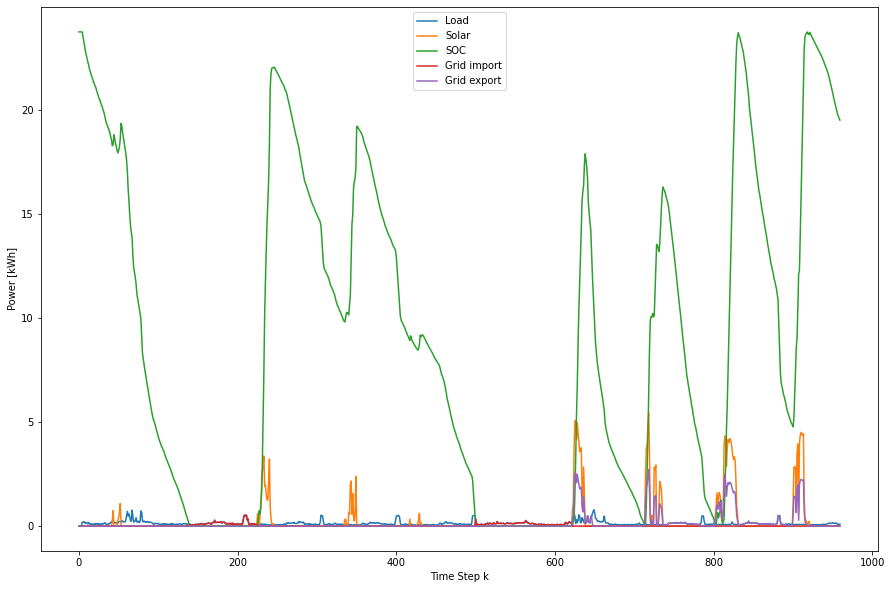

In [24]:
microgrid(75,20, LoadFactor=0.5)